# Phased Array Microphonics

## This is the official transfer of matlab code to python. The code itself can be found at: 
### https://github.com/gruenkyle/Phased_Array_Microphonics ###

#### Written by: Kyle Gruen 
---


In [1]:
#The following import statements are necessary for running this program
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#### Now that import statements have been created, the fields are next. We have a few major fields necessary to intialize such as:
- Speed of Sound
- Sample Rate of Speed
- Duration of Signals
- Type of Signals


In [2]:
#Initializing unchanging field variables for later calculations

#FIELDS#
SOUND_SPEED = 343 #speed of sound in meters per second
FS = 44100 #Avg number of samples obtained per second
CYCLES = 1 #Number of cycles each sound wave will run
DURATION_OF_SIGNAL = CYCLES * (1/440) #Duration calculated for wave length
T = np.arange(0, DURATION_OF_SIGNAL, 1/FS) #Create array of zeros for total signal length

#TYPE OF SIGNAL#
SMALLSIGNAL = np.sin(2 * np.pi * 1000 * T) # 1 kHz signal
MEDIUMSIGNAL = np.sin(2 * np.pi * 1700 * T) # 1.7 kHz signal
LARGESIGNAL = np.sin(2 * np.pi * 2430 * T) # 2.4 kHz signal

### After all fields have been created, the parameters of the system are next ###

The system general idea of the system is spread between a set of microphones where the targeted sound location adjacent distance and opposite distance in relation to the system are given. 

If the OppDist is negative then the sound is to the left of the center, but if it is to the right then it will be positive.

![system image](./soundimage.png)

In [3]:
TOTAL_SPREAD = 10.0 # Spread of Array in Meters
MIC_COUNT = 5 # Total number of microphones being used
CENTER = TOTAL_SPREAD / 2 # Calculated Center of System
FORLOOPARR = np.arange(MIC_COUNT) # Array for iterating over every microphone is essential
SCALAR = TOTAL_SPREAD / (MIC_COUNT - 1)

SYS_ADJ_DIST = 5 # Adjacent Distance to Sound
SYS_OPP_DIST = 7.5 # Opposite Distance to Sound

orientationTarget = "R" # Default to the right of the system center

In [4]:
MIC_DISTANCES_TO_START = np.zeros(MIC_COUNT, dtype=float) # Create Storage Array for Mic Distances to Center
MIC_DISTANCES_TO_TARGET = np.zeros(MIC_COUNT, dtype=float)
for index in FORLOOPARR:
    MIC_DISTANCES_TO_START[index] = ((SCALAR*index))

MIC_DISTANCES_TO_START[0] = 0

for index in FORLOOPARR:
    if (MIC_DISTANCES_TO_START[index] > SYS_OPP_DIST):
        MIC_DISTANCES_TO_TARGET[index] = SYS_OPP_DIST - MIC_DISTANCES_TO_START[index]
    elif (MIC_DISTANCES_TO_START[index] < SYS_OPP_DIST) :
         MIC_DISTANCES_TO_TARGET[index] = abs(SYS_OPP_DIST - MIC_DISTANCES_TO_START[index])

print(MIC_DISTANCES_TO_START)
MIC_DISTANCES_TO_TARGET = abs(MIC_DISTANCES_TO_TARGET)
print(MIC_DISTANCES_TO_TARGET)


for index in FORLOOPARR:
    MIC_DISTANCES_TO_TARGET[index] = ((MIC_DISTANCES_TO_TARGET[index])**2 + SYS_ADJ_DIST**2)**(1/2)

print(MIC_DISTANCES_TO_TARGET)

[ 0.   2.5  5.   7.5 10. ]
[7.5 5.  2.5 0.  2.5]
[9.01387819 7.07106781 5.59016994 5.         5.59016994]


Find the maximum and minimum distances / indexes from distance array

In [5]:
minDistance = np.min(MIC_DISTANCES_TO_TARGET)
closestMicIndex = np.argmin(MIC_DISTANCES_TO_TARGET)

maxDistance = np.max(MIC_DISTANCES_TO_TARGET)
furthestMicIndex = np.argmax(MIC_DISTANCES_TO_TARGET)

Create Delay Calculation and Sample Delay Calculation

- Delay Calculation = Distance / Sound_Speed
- Sample Delay = Delay * FS <- Sample Rate Speed 

In [6]:
delayTarget = np.zeros(MIC_COUNT, dtype=float)
sampleDelayTarget = np.zeros(MIC_COUNT, dtype=float)

# Calculate Delay of Samples for Targeted Sound to Microphones #

for mic in FORLOOPARR:
    delayTarget[mic] = (MIC_DISTANCES_TO_TARGET[mic] / SOUND_SPEED)
    sampleDelayTarget[mic] = np.round(delayTarget[mic] * FS)

Find Total Delay Between All Microphones In Relation To The Furthest Microphone Distance Which Will Later Be Used For Microphone Delay Offest

In [7]:
totalSampleDelay = np.zeros(MIC_COUNT, dtype=float)

for mic in FORLOOPARR:
    totalSampleDelay[mic] = np.round(sampleDelayTarget[furthestMicIndex] - sampleDelayTarget[mic])

abs(totalSampleDelay)

array([  0., 250., 440., 516., 440.])

Now that all values have been gathered, we can use them to create the different arrays for each microphone input synthetically. This is all based on the idea that each microphone will receive audio data that can be put into a csv array. 

By knowing the sample rate, the replication of what a possible array data would be created.

In [8]:
micSignalCells = [np.array([]) for _ in range(MIC_COUNT)]
maxSignalArrLengths = np.zeros(MIC_COUNT, dtype=int)

for mic in FORLOOPARR:
    sampleDelayTarget[mic] = int(sampleDelayTarget[mic])
    micSignalCells[mic] = np.append(micSignalCells[mic], np.zeros(int(sampleDelayTarget[mic])))
    micSignalCells[mic] = np.append(micSignalCells[mic], LARGESIGNAL)
    micSignalCells[mic] = np.append(micSignalCells[mic], np.zeros(20))
    maxSignalArrLengths[mic] = len(micSignalCells[mic])

Now that all the microphone arrays have been made, each ones total length needs to be evened out so matplotlib can properly graph each sound. In the case where multiple sounds are present, this will need to take place at the very end of the program.

In [9]:
maxSize = np.max(maxSignalArrLengths)

for mic in FORLOOPARR:
    appendedZero = maxSize - maxSignalArrLengths[mic]
    micSignalCells[mic] = np.append(micSignalCells[mic], np.zeros(appendedZero))
    print(appendedZero)



0
250
440
516
440


Now all arrays of data have been created and equalized, this means that the last step necessary is to use matplotlib to graph

(-2.0, 2.0)

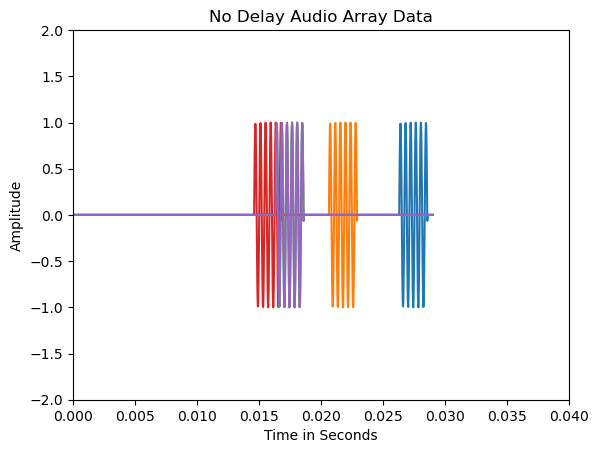

In [10]:
for mic in FORLOOPARR:
    time_values = np.arange(1/FS, (maxSize + 1)/FS, 1/FS)
    plt.plot(time_values, micSignalCells[mic], label=f'Microphone {mic}')

plt.title("No Delay Audio Array Data")
plt.xlabel("Time in Seconds")
plt.ylabel("Amplitude")
plt.xlim(0,0.04)
plt.ylim(-2,2)


In [11]:
maxLengthsDelayAdd = np.zeros(MIC_COUNT)

for mic in FORLOOPARR:
    if (mic != furthestMicIndex):
        micSignalCells[mic] = np.append(np.zeros(int(totalSampleDelay[mic])), micSignalCells[mic])
    maxLengthsDelayAdd[mic] = len(micSignalCells[mic])
print(maxLengthsDelayAdd)

[1280. 1530. 1720. 1796. 1720.]


In [13]:
maxSize = np.max(maxLengthsDelayAdd)
print(maxSize)

1796.0


In [15]:
for mic in FORLOOPARR:
    micSignalCells[mic] = np.append(micSignalCells[mic], np.zeros(int(maxSize - maxLengthsDelayAdd[mic])))
    print(len(micSignalCells[mic]))

1796
1796
1796
1796
1796


(-2.0, 2.0)

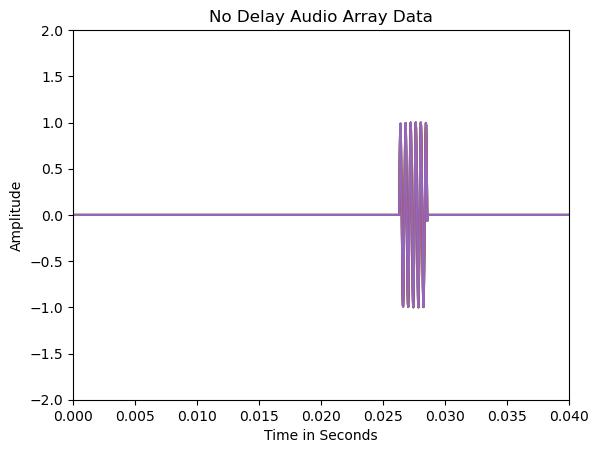

In [16]:
for mic in FORLOOPARR:
    time_values = np.arange(1/FS, (maxSize + 1)/FS, 1/FS)
    plt.plot(time_values, micSignalCells[mic], label=f'Microphone {mic}')

plt.title("No Delay Audio Array Data")
plt.xlabel("Time in Seconds")
plt.ylabel("Amplitude")
plt.xlim(0,0.04)
plt.ylim(-2,2)

In [19]:
micSumSignal = np.zeros(int(maxSize))
for finalSummationMic in FORLOOPARR:
    micSumSignal = micSumSignal + micSignalCells[int(finalSummationMic)]

(-2.0, 2.0)

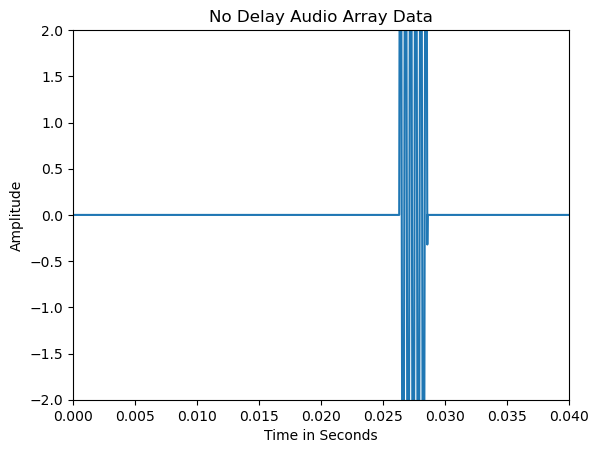

In [20]:
plt.plot(time_values, micSumSignal, label=f'Microphone {mic}')

plt.title("No Delay Audio Array Data")
plt.xlabel("Time in Seconds")
plt.ylabel("Amplitude")
plt.xlim(0,0.04)
plt.ylim(-2,2)